### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 C9 40 4C 40 5...|1951.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[E0 D4 30 D5 F0 D...|1952.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 4D 80 4D A0 5...|1953.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
import pandas_profiling
pandas_df = df.toPandas()
pandas_df_1 = pandas_df.drop('vector', axis=1)
pandas_profiling.ProfileReport(pandas_df_1)


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Number of variables,8
Number of observations,12376
Total Missing (%),0.0%
Total size in memory,773.6 KiB
Average record size in memory,64.0 B
Numeric,5
Categorical,2
Date,0
Text (Unique),0
Rejected,1
Distinct count,86


In [3]:
snwd = STAT['SNWD']
print type(snwd)
print snwd.keys()
# snwd_df = pd.DataFrame.from_dict(snwd)

<type 'dict'>
['std', 'UnDef', 'E', 'Cov', 'high1000', 'NE', 'O', 'low100', 'NO', 'high100', 'eigvec', 'low1000', 'Var', 'eigval', 'mean', 'SortedVals', 'Mean']


### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
from YearPlotter import YearPlotter
YP=YearPlotter()

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
#     fig.autofmt_xdate()
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

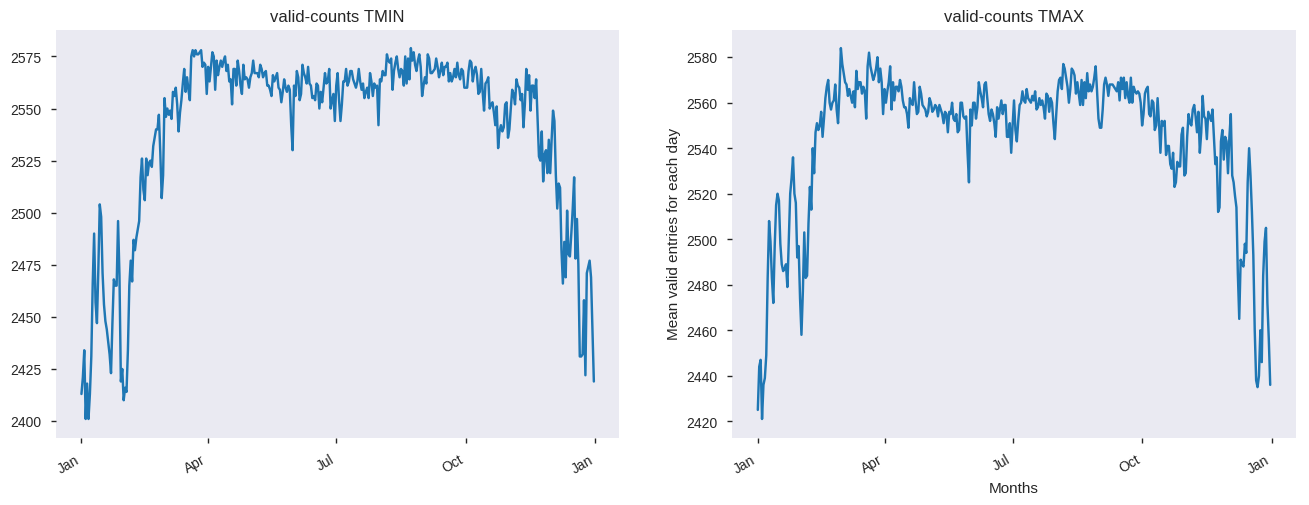

In [7]:
plot_pair(['TMIN','TMAX'],plot_valid)
xlabel("Months")
ylabel("Mean valid entries for each day")

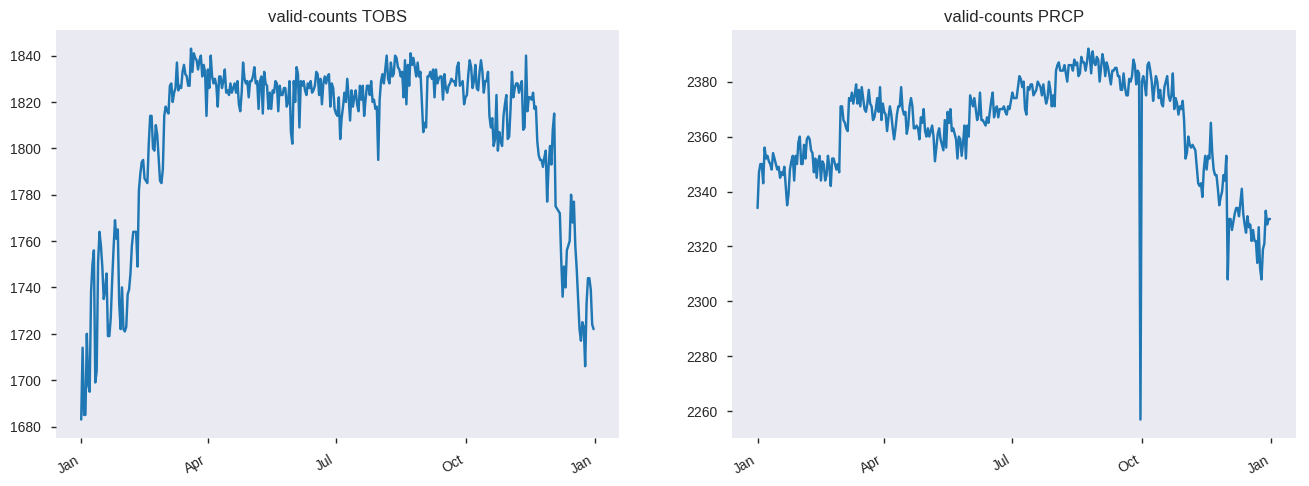

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid)

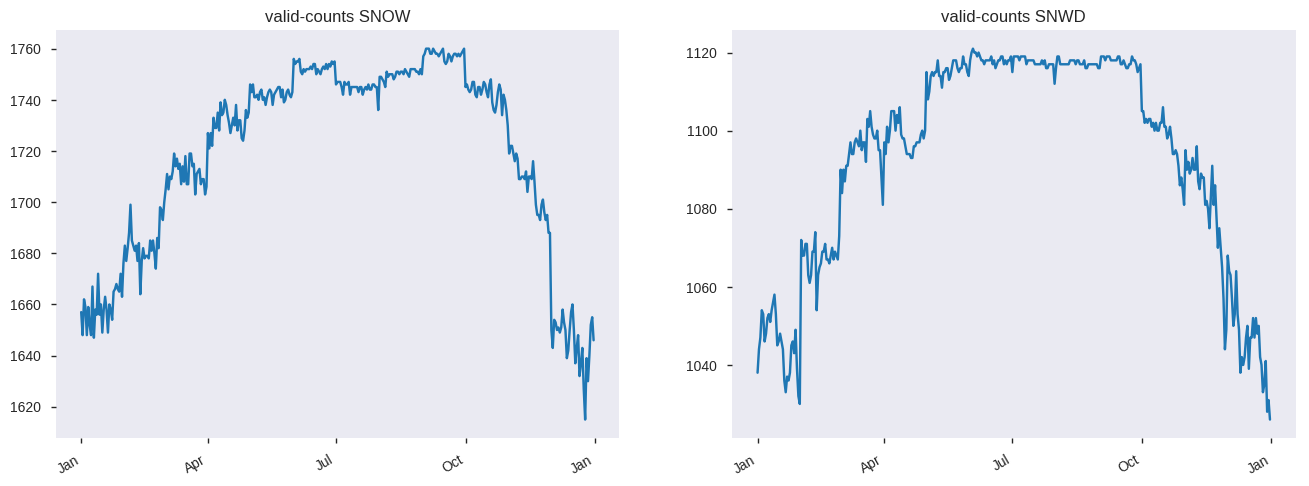

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [10]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

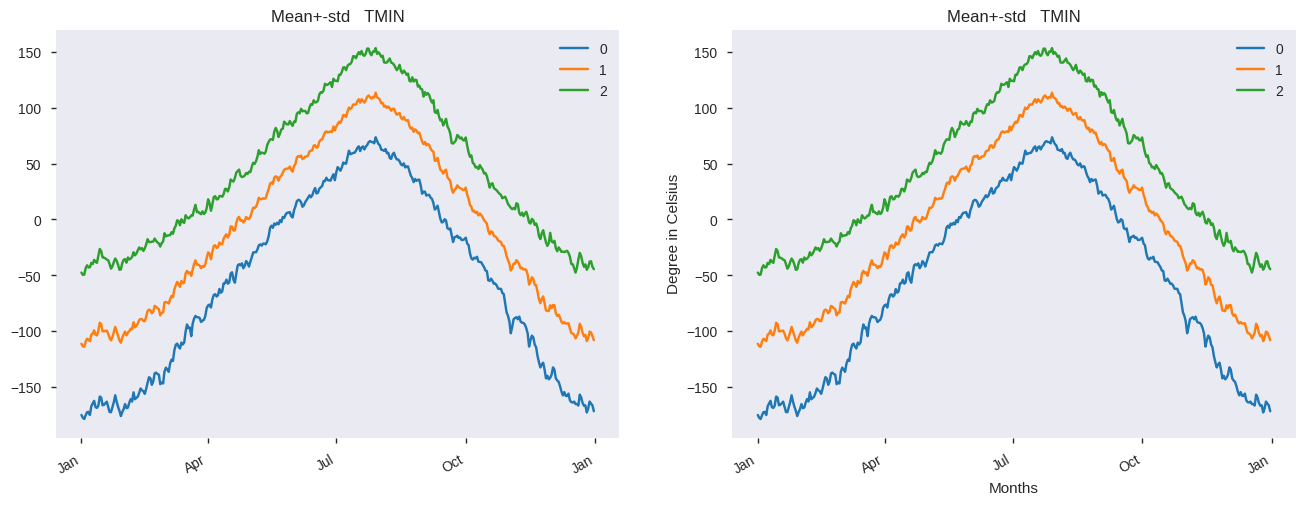

In [11]:
plot_pair(['TMIN','TMIN'],plot_mean_std)
xlabel("Months");
ylabel("Degree in Celsius");

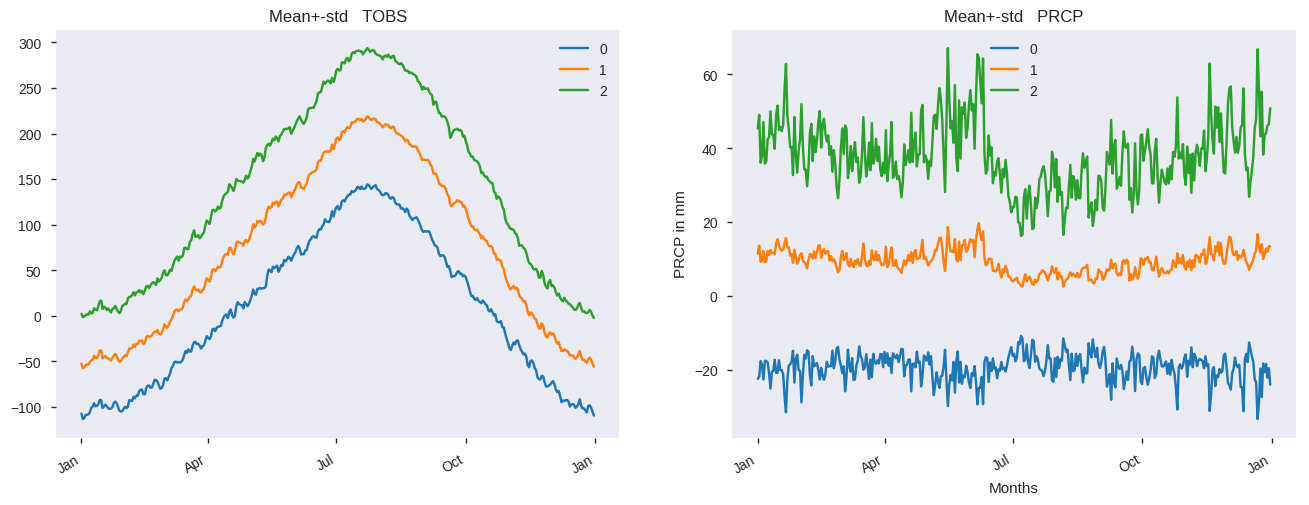

In [12]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
xlabel("Months");
ylabel("PRCP in mm");

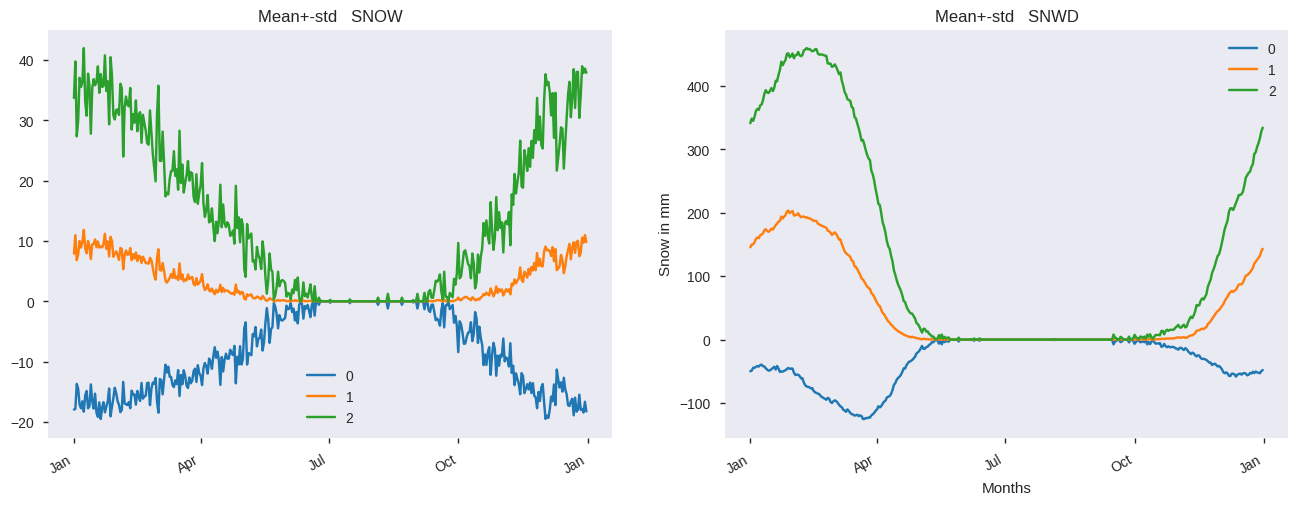

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
xlabel("Months");
ylabel("Snow in mm");